# MQ-7

## Ro calculation

### Specifications

#### Standard Work Condition

    Vc    (Circuit Voltage)        :  5v +/- 0.1
    VH(h) (Heating Voltage - high) :  5v +/- 0.1
    VH(l) (Heating Voltage - low)  :  1.4v +/- 0.1
    RL    (Load Resistance)        :  can adjust
    RH    (Heater Resistance)      :  33 Ohm +/- 5%
    TH(H) (Heating time (high)     :  60 +/- 1 seconds
    TH(L) (Heating time (low)      :  90 +/- 1 seconds
    PH    (Heating consumption)    :  about 350 mW
    

#### Sensitivity Characteristic:

    Rs (Sensing Resistance)    : 2kOhm  -  20kOhm (100ppm Carbon Monoxide)
    Preheat Time               : No less than 48 hours
    
    Detecting range:
        Carbon Monoxide:  20ppm  - 2000ppm 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [2]:
## Gas concentration values referenced in the datasheet
POINTS = {
     # Carbon Monoxide
    'co' : {
        'p1' : {'x': 50,   'y':1.605},
        'p2' : {'x': 100,  'y':1.000},
        'p3' : {'x': 400,  'y':0.381},
        'p4' : {'x': 1000, 'y':0.217},
        'p5' : {'x': 4000, 'y':0.090}
    },

    # Hydrogen
    'h2' : {
        'p1' : {'x': 50,   'y':1.278},
        'p2' : {'x': 100,  'y':0.792},
        'p3' : {'x': 400,  'y':0.276},
        'p4' : {'x': 1000, 'y':0.141},
        'p5' : {'x': 4000, 'y':0.052}
    },

    # Liquefied Petroleum Gas
    'lpg' : {
        'p1' : {'x': 50,   'y':9.005},
        'p2' : {'x': 100,  'y':7.989},
        'p3' : {'x': 400,  'y':6.675},
        'p4' : {'x': 1000, 'y':5.993},
        'p5' : {'x': 4000, 'y':4.948}
    },

    # Methane
    'ch4' : {
        'p1' : {'x': 50,   'y':13.859},
        'p2' : {'x': 100,  'y':12.745},
        'p3' : {'x': 400,  'y':11.720},
        'p4' : {'x': 1000, 'y':11.039},
        'p5' : {'x': 4000, 'y':9.005}
    },

    'alcohol' : {
        'p1' : {'x': 50,   'y':16.194},
        'p2' : {'x': 100,  'y':14.715},
        'p3' : {'x': 400,  'y':13.054},
        'p4' : {'x': 1000, 'y':12.745},
        'p5' : {'x': 4000, 'y':12.004}
    },    
}


AIR = 25.836

GASES = ['co', 'h2', 'lpg', 'ch4', 'alcohol']

In [3]:
# RS value calculation
Rs    = lambda Vcc, Vrl, RL : ((Vcc * RL) / Vrl) - RL

# R0 value calculation
R0    = lambda Rs, air : Rs / air

# RS/Ro value calculation (ratio)
Ratio = lambda Rs, R0: Rs / R0

# log(y) = m.log(x) + b
# m
M     = lambda p1, p2 : (math.log10( p2['y'] / p1['y'] )) / (math.log10(p2['x']/p1['x']))
# b
B     = lambda p, m : math.log10(p['y']) - (m * math.log10(p['x']))

# PPM value calculation 
PPM   = lambda  y, m, b: 10 ** ((math.log10(y) - b) / m)

In [4]:
## Calculate the points to be used for the calculation of _m_ and _b_ according to the _ratio_ value 
def getPoints(racio, values):
    size = len(values)
    for idx in range(size - 1):
        if racio >= values[idx]['y']:
            if idx == 0:
                return (values[0], values[1])
            return(values[idx - 1], values[idx])
    return(values[size - 2], values[size - 1])

In [5]:
pList = {}
for gas in GASES:
    pList[gas] = list(POINTS[gas].values())

In [6]:
col_list = ["date", "mq7_1", "mq7_2"]
df = pd.read_csv('empty_210622_1100.csv', usecols=col_list)

df['date']= pd.to_datetime(df['date'])

mq7_1 = df[["date","mq7_1"]]
mq7_2 = df[["date","mq7_2"]]

### Ro values to be considered

- __Sensor 1__: 12.51 kOhms
- __Sensor 2__: 5.66 kOhms 

In [7]:
# MQ 7 - sensor 1
sensor1 = {}
sensor1['Vcc'] = 5      #volts
sensor1['RL']  = 10     #kOhms
sensor1['AIR'] = AIR   
sensor1['Ro']  = 12.51  #kOhms

# MQ 7 - sensor 2
sensor2 = {}
sensor2['Vcc'] = 5      #volts
sensor2['RL']  = 10     #kOhms
sensor2['AIR'] = AIR   
sensor2['Ro']  = 5.66   #kOhms

In [8]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq7_1['mq7_1'].min(),
    mq7_1['mq7_1'].mean(), 
    mq7_1['mq7_1'].quantile(0.25),
    mq7_1['mq7_1'].quantile(0.5),
    mq7_1['mq7_1'].quantile(0.75),
    mq7_1['mq7_1'].max()]

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in Vrl]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []

for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

In [9]:
# Min; Mean; Median; Quantile [0.25, 0.5, 0.75]; Max

Vrl = [
    mq7_2['mq7_2'].min(),
    mq7_2['mq7_2'].mean(), 
    mq7_2['mq7_2'].quantile(0.25),
    mq7_2['mq7_2'].quantile(0.5),
    mq7_2['mq7_2'].quantile(0.75),
    mq7_2['mq7_2'].max()]

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in Vrl]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]

ppm2 = {}
for gas in GASES:
    ppm2[gas] = []

for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

In [10]:
print(f"Period in which the readings were carried out: {mq7_1['date'].min()} - {mq7_1['date'].max()} \n")

print("Sensor 1")


print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor1['Ratio'][0],3),
               round(sensor1['Ratio'][1],3),
               round(sensor1['Ratio'][2],3),
               round(sensor1['Ratio'][3],3),
               round(sensor1['Ratio'][4],3),
               round(sensor1['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm1[gas][0],3),
                   round(ppm1[gas][1],3),
                   round(ppm1[gas][2],3),
                   round(ppm1[gas][3],3),
                   round(ppm1[gas][4],3),
                   round(ppm1[gas][5],3)))
    
print("-"*(12*7))
    
print("Sensor 2")

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('', 'Min', 'Mean', '1Q', '2Q', '3Q', 'Max'))

print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
       .format('Rs/Ro', 
               round(sensor2['Ratio'][0],3),
               round(sensor2['Ratio'][1],3),
               round(sensor2['Ratio'][2],3),
               round(sensor2['Ratio'][3],3),
               round(sensor2['Ratio'][4],3),
               round(sensor2['Ratio'][5],3)))

for gas in GASES:
    print ("{:<12} {:<12} {:<12} {:<12} {:<12} {:<12} {:<12}"
           .format(gas.upper(), 
                   round(ppm2[gas][0],3),
                   round(ppm2[gas][1],3),
                   round(ppm2[gas][2],3),
                   round(ppm2[gas][3],3),
                   round(ppm2[gas][4],3),
                   round(ppm2[gas][5],3)))

Period in which the readings were carried out: 2022-06-21 11:00:00 - 2022-06-21 11:45:00 

Sensor 1
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        56.298       44.822       49.161       43.61        43.61        39.169      
CO           0.273        0.381        0.332        0.396        0.396        0.464       
H2           0.208        0.289        0.253        0.301        0.301        0.351       
LPG          0.001        0.005        0.003        0.005        0.005        0.01        
CH4          0.0          0.003        0.001        0.004        0.004        0.009       
ALCOHOL      0.006        0.032        0.016        0.038        0.038        0.084       
------------------------------------------------------------------------------------
Sensor 2
             Min          Mean         1Q           2Q           3Q           Max         
Rs/Ro        36.642       32.876       33.569       33.569       32.21        

In [11]:
font = {
    'family': 'serif',
    'color':  'tab:red',
    'weight': 'normal',
    'size': 14
}

font_title = {
    'family': 'serif',
    'color':  'tab:blue',
    'weight': 'normal',
    'size': 16,
}

colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
          'tab:brown', 'tab:pink', 'tab:gray','tab:olive','tab:cyan']

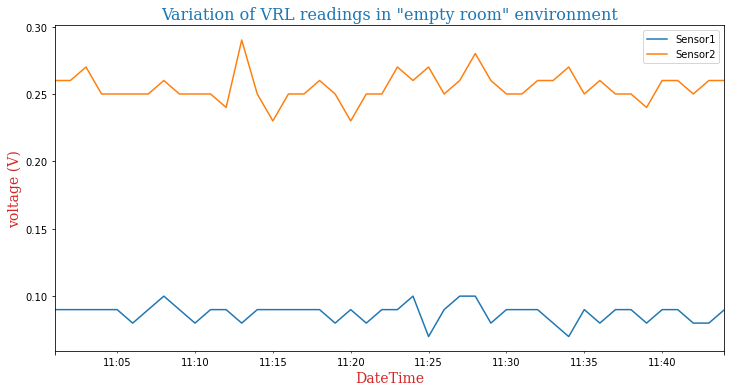

In [12]:
fdf = df[(df['date'] > '6/21/22 11:00 AM') & (df['date'] < '6/21/22 11:45 AM')]

ax = fdf.plot(x='date', y=["mq7_1","mq7_2"], 
              kind="line", figsize=(12, 6))

plt.title('Variation of VRL readings in "empty room" environment', fontdict=font_title)
plt.xlabel('DateTime',    fontdict=font)
plt.ylabel('voltage (V)', fontdict=font)
plt.legend(['Sensor1', 'Sensor2'], loc='best')


plt.show()

In [13]:
# MQ 7 Sensor1

sensor1['Rs'] = [Rs(sensor1['Vcc'] , v, sensor1['RL'] ) for v in mq7_1["mq7_1"]]
sensor1['Ratio'] = [Ratio(rs, sensor1['Ro']) for rs in sensor1['Rs']]

ppm1 = {}
for gas in GASES:
    ppm1[gas] = []
    
for r in sensor1['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm1[gas].append(PPM(r, m, b))

for gas in GASES:
    mq7_1[gas] = ppm1[gas]

In [14]:
# MQ 7 Sensor 2

sensor2['Rs'] = [Rs(sensor2['Vcc'] , v, sensor2['RL'] ) for v in mq7_2["mq7_2"]]
sensor2['Ratio'] = [Ratio(rs, sensor2['Ro']) for rs in sensor2['Rs']]
  
ppm2 = {}
for gas in GASES:
    ppm2[gas] = []
    
for r in sensor2['Ratio']:
    for gas in GASES:    
        p1, p2 = getPoints(r, pList[gas])
        m = M(p1, p2)
        b = B(p1, m)
        ppm2[gas].append(PPM(r, m, b))

for gas in GASES:
    mq7_2[gas] = ppm2[gas]

In [15]:
mq7_1.describe()

,mq7_1,co,h2,lpg,ch4,alcohol
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,0.087609,0.381464,0.289627,0.004976,0.003565,0.035670
std,0.006728,0.043092,0.032365,0.002073,0.002117,0.018500
min,0.070000,0.272554,0.207734,0.001230,0.000461,0.006061
25%,0.080000,0.332434,0.252809,0.002697,0.001414,0.016168
50%,0.090000,0.396224,0.300727,0.005398,0.003809,0.038482
75%,0.090000,0.396224,0.300727,0.005398,0.003809,0.038482
max,0.100000,0.463740,0.351350,0.010053,0.009261,0.083720


In [16]:
mq7_2.describe()

,mq7_2,co,h2,lpg,ch4,alcohol
count,46.000000,46.000000,46.000000,46.000000,46.000000,46.000000
mean,0.255000,0.599877,0.453173,0.028528,0.042022,0.311830
std,0.010904,0.039857,0.029766,0.008077,0.018087,0.114266
min,0.230000,0.511339,0.386989,0.014792,0.016078,0.135661
25%,0.250000,0.581346,0.439339,0.024561,0.033180,0.255707
50%,0.250000,0.581346,0.439339,0.024561,0.033180,0.255707
75%,0.260000,0.617633,0.466445,0.031201,0.046703,0.344861
max,0.290000,0.731559,0.551435,0.060915,0.121463,0.795847


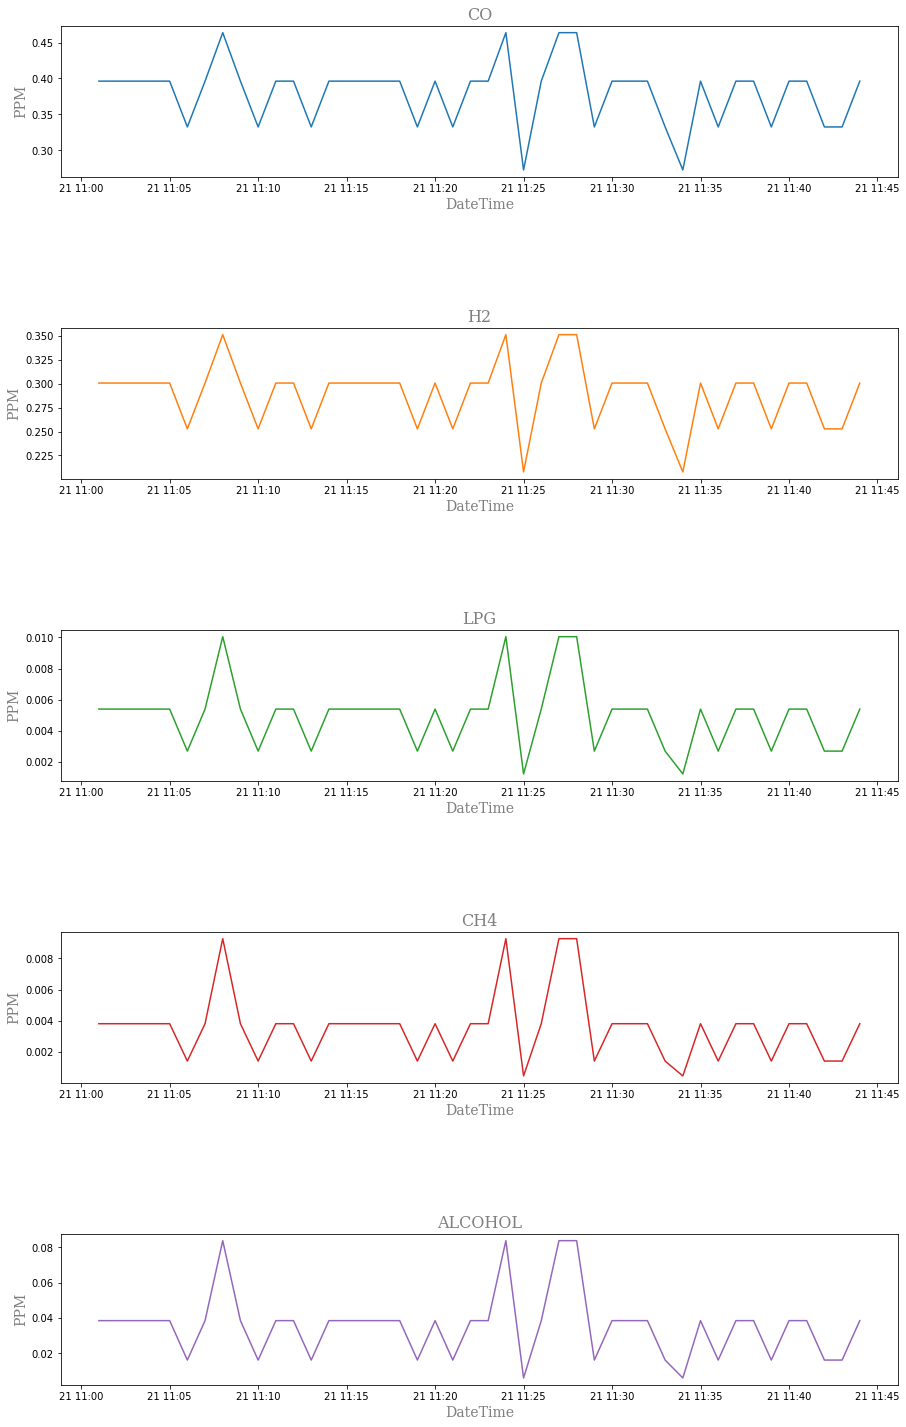

In [17]:
# Time Interval:
#           min: 2022-06-21 11:00:00
#           max: 2022-06-21 11:45:00 
  
fmq = mq7_1[(mq7_1['date'] > '6/21/22 11:00 AM') & (mq7_1['date'] < '6/21/22 11:45 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()

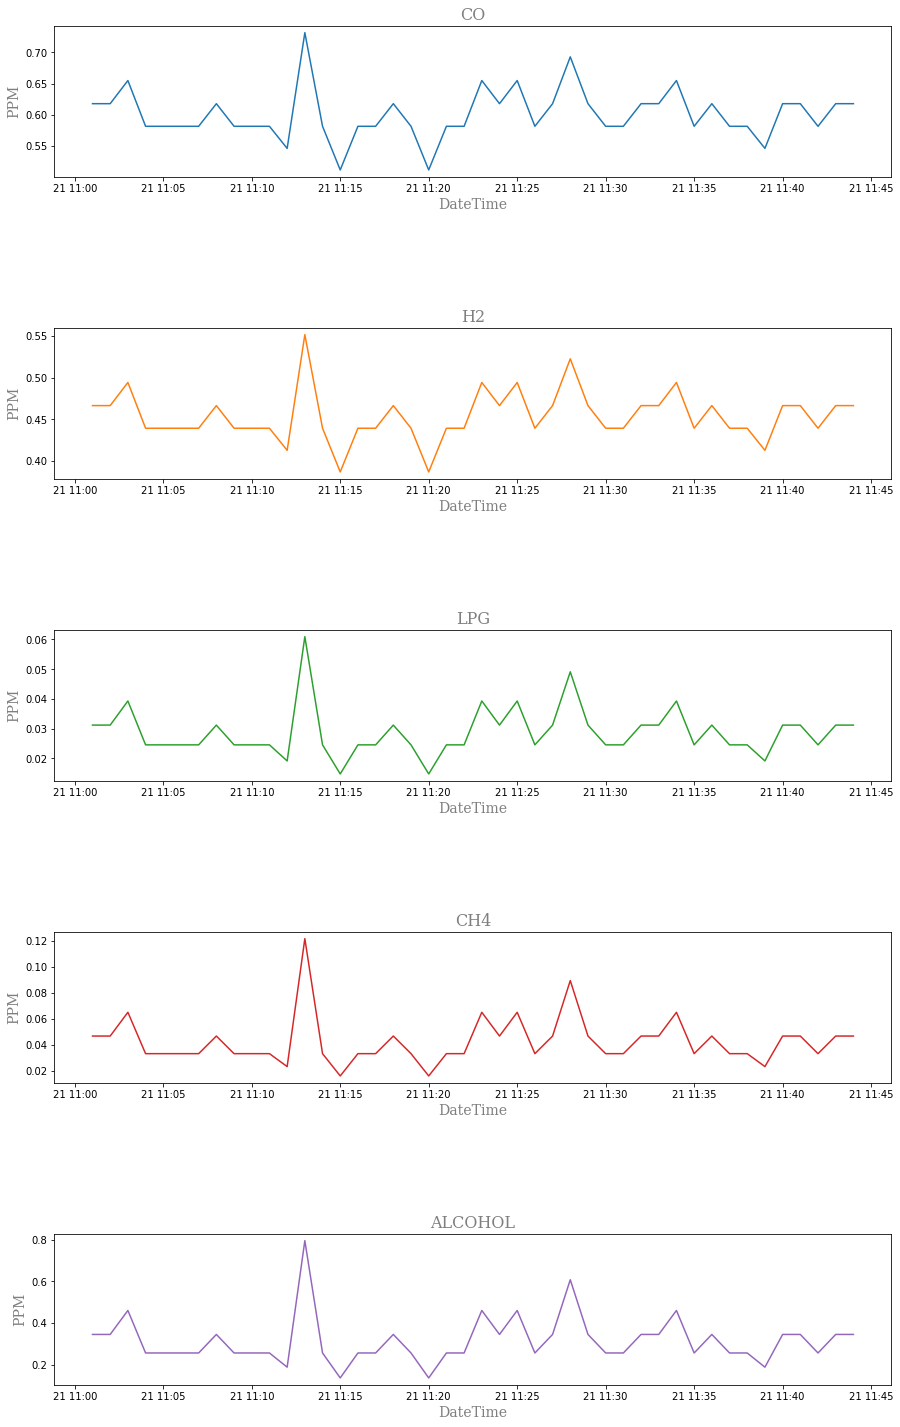

In [18]:
# Time Interval:
#           min: 2022-06-21 11:00:00
#           max: 2022-06-21 11:45:00 
  
fmq = mq7_2[(mq7_2['date'] > '6/21/22 11:00 AM') & (mq7_2['date'] < '6/21/22 11:45 AM')]

plt.figure(figsize=(15, 25))
plt.subplots_adjust(hspace = 1)

for idx in range(len(GASES)):
    plt.subplot(len(GASES) * 100 + 11 + idx)
    plt.plot(fmq['date']         , fmq[GASES[idx]],        color=colors[idx])
    plt.xlabel('DateTime'        , fontdict=font,          color='tab:gray')
    plt.ylabel('PPM'             , fontdict=font,          color='tab:gray')
    plt.title(GASES[idx].upper() , fontdict=font_title,    color='tab:gray')
    


plt.show()

In [19]:
# Save in excel file
mq7_1.to_csv('mq7_1.csv')
mq7_2.to_csv('mq7_2.csv')